<a href="https://colab.research.google.com/github/Willi-blip/numpy1/blob/main/Projecto_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Celda 1: Instalar dependencias
!pip install tensorflow opencv-python matplotlib tensorflowjs

In [ ]:
# Celda 2: Importar librerías
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Verificando estructura de carpetas...
¿Existe dataset_dir? True
¿Existe gatos_dir? True
¿Existe perros_dir? True

Imágenes encontradas:
Gatos: 11 imágenes
Perros: 12 imágenes

Archivos en gatos: ['g9.jpeg', 'g10.jpeg', 'g11.jpeg', 'g5.jpeg', 'g3.jpg', 'g7.jpeg', 'g1.jpg', 'g4.jpeg', 'g8.jpeg', 'g2.png', 'g6.jpeg']
Archivos en perros: ['p5.jpeg', 'p12.jpeg', 'p10.jpeg', 'p4.jpeg', 'p3.jpeg', 'toby.jpg', 'p11.jpeg', 'p9.jpeg', 'p1.jpeg', 'p8.jpeg', 'p2.jpeg', 'p6.jpeg']


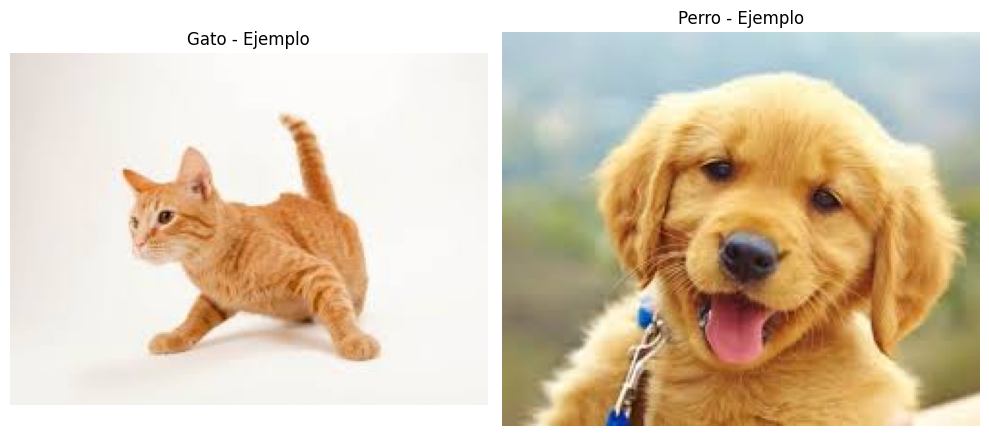

In [ ]:
# Celda 3: Configurar paths y verificar imágenes (CORREGIDO)
# Configurar las rutas según tu estructura - SIN Google Drive
dataset_dir = '/content/dataset'  # Esta es la carpeta que ya creaste
gatos_dir = os.path.join(dataset_dir, 'gatos')
perros_dir = os.path.join(dataset_dir, 'perros')

# Verificar que las carpetas existen
print("Verificando estructura de carpetas...")
print(f"¿Existe dataset_dir? {os.path.exists(dataset_dir)}")
print(f"¿Existe gatos_dir? {os.path.exists(gatos_dir)}")
print(f"¿Existe perros_dir? {os.path.exists(perros_dir)}")

# Contar imágenes
if os.path.exists(gatos_dir):
    gatos_imgs = [f for f in os.listdir(gatos_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
else:
    gatos_imgs = []

if os.path.exists(perros_dir):
    perros_imgs = [f for f in os.listdir(perros_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
else:
    perros_imgs = []

print("\nImágenes encontradas:")
print(f"Gatos: {len(gatos_imgs)} imágenes")
print(f"Perros: {len(perros_imgs)} imágenes")

# Mostrar nombres de archivos para debugging
if gatos_imgs:
    print(f"\nArchivos en gatos: {gatos_imgs}")
if perros_imgs:
    print(f"Archivos en perros: {perros_imgs}")

# Mostrar algunas imágenes de ejemplo si existen
if gatos_imgs and perros_imgs:
    plt.figure(figsize=(10, 5))

    # Mostrar un gato
    plt.subplot(1, 2, 1)
    gato_img = cv2.imread(os.path.join(gatos_dir, gatos_imgs[0]))
    if gato_img is not None:
        gato_img = cv2.cvtColor(gato_img, cv2.COLOR_BGR2RGB)
        plt.imshow(gato_img)
        plt.title('Gato - Ejemplo')
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, 'Error cargando imagen', ha='center')
        plt.title('Error')

    # Mostrar un perro
    plt.subplot(1, 2, 2)
    perro_img = cv2.imread(os.path.join(perros_dir, perros_imgs[0]))
    if perro_img is not None:
        perro_img = cv2.cvtColor(perro_img, cv2.COLOR_BGR2RGB)
        plt.imshow(perro_img)
        plt.title('Perro - Ejemplo')
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, 'Error cargando imagen', ha='center')
        plt.title('Error')

    plt.tight_layout()
    plt.show()
else:
    print("\nERROR: No se encontraron imágenes o carpetas.")
    print("Por favor verifica:")
    print("1. Que la carpeta 'dataset' existe en /content/")
    print("2. Que dentro de 'dataset' hay carpetas 'gatos' y 'perros'")
    print("3. Que las carpetas contienen imágenes en formatos .jpg, .jpeg o .png")

In [ ]:
# Celda 4: Preprocesamiento de imágenes (CORREGIDO)
IMG_SIZE = 150  # Tamaño al que redimensionaremos las imágenes

def cargar_imagenes(data_dir, etiqueta):
    imagenes = []
    etiquetas = []

    if not os.path.exists(data_dir):
        print(f"Directorio no encontrado: {data_dir}")
        return np.array(imagenes), np.array(etiquetas)

    # Solo procesar archivos de imagen
    archivos_imagen = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not archivos_imagen:
        print(f"No se encontraron imágenes en: {data_dir}")
        return np.array(imagenes), np.array(etiquetas)

    for img_name in archivos_imagen:
        try:
            img_path = os.path.join(data_dir, img_name)
            img_arr = cv2.imread(img_path)
            if img_arr is None:
                print(f"No se pudo cargar (formato no compatible?): {img_path}")
                continue
            img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # Convertir a RGB
            imagenes.append(img_arr)
            etiquetas.append(etiqueta)
            print(f"✓ {img_name} cargado correctamente")
        except Exception as e:
            print(f"Error procesando imagen {img_path}: {e}")

    return np.array(imagenes), np.array(etiquetas)

print("Cargando imágenes de gatos...")
X_gatos, y_gatos = cargar_imagenes(gatos_dir, 0)  # 0 para gatos

print("\nCargando imágenes de perros...")
X_perros, y_perros = cargar_imagenes(perros_dir, 1)  # 1 para perros

# Verificar que tenemos imágenes
if len(X_gatos) == 0 or len(X_perros) == 0:
    print("\nERROR: No se pudieron cargar imágenes. Verifica:")
    print("1. Los formatos de imagen (usar .jpg, .png)")
    print("2. Que las imágenes no estén corruptas")
    print("3. Que los nombres de archivo no tengan caracteres especiales")
else:
    # Combinar datos
    X = np.concatenate((X_gatos, X_perros))
    y = np.concatenate((y_gatos, y_perros))

    # Mezclar los datos
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Normalizar los datos
    X = X / 255.0

    print(f"\nResumen del dataset:")
    print(f"Total de imágenes: {X.shape[0]}")
    print(f"Forma de las imágenes: {X.shape[1:]}")
    print(f"Gatos: {len(X_gatos)}, Perros: {len(X_perros)}")

Cargando imágenes de gatos...
✓ g9.jpeg cargado correctamente
✓ g10.jpeg cargado correctamente
✓ g11.jpeg cargado correctamente
✓ g5.jpeg cargado correctamente
✓ g3.jpg cargado correctamente
✓ g7.jpeg cargado correctamente
✓ g1.jpg cargado correctamente
✓ g4.jpeg cargado correctamente
✓ g8.jpeg cargado correctamente
✓ g2.png cargado correctamente
✓ g6.jpeg cargado correctamente

Cargando imágenes de perros...
✓ p5.jpeg cargado correctamente
✓ p12.jpeg cargado correctamente
✓ p10.jpeg cargado correctamente
✓ p4.jpeg cargado correctamente
✓ p3.jpeg cargado correctamente
✓ toby.jpg cargado correctamente
✓ p11.jpeg cargado correctamente
✓ p9.jpeg cargado correctamente
✓ p1.jpeg cargado correctamente
✓ p8.jpeg cargado correctamente
✓ p2.jpeg cargado correctamente
✓ p6.jpeg cargado correctamente

Resumen del dataset:
Total de imágenes: 23
Forma de las imágenes: (150, 150, 3)
Gatos: 11, Perros: 12


Imágenes de entrenamiento: 18
Imágenes de prueba: 5

Ejemplo de aumento de datos:


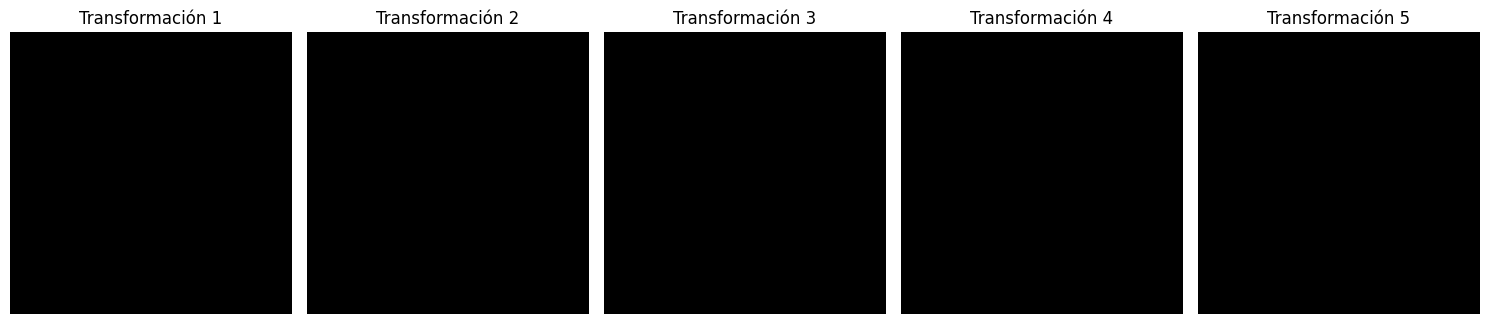

In [ ]:
# Celda 5: Dividir datos y aumentar datos
if 'X' in locals() and X.shape[0] > 0:
    # Para pocos datos, usamos validación cruzada o más datos de entrenamiento
    if X.shape[0] < 20:
        # Si tenemos muy pocos datos, usar solo 10% para prueba
        test_size = 0.1
        print("Pocos datos detectados. Usando 90% entrenamiento, 10% prueba")
    else:
        test_size = 0.2

    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    print(f"Imágenes de entrenamiento: {X_entrenamiento.shape[0]}")
    print(f"Imágenes de prueba: {X_prueba.shape[0]}")

    # Aumento de datos - muy importante con pocas imágenes
    aumento_datos = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.3,
        shear_range=0.3,
        brightness_range=[0.7, 1.3],
        fill_mode='nearest'
    )

    # Mostrar ejemplo de aumento de datos
    print("\nEjemplo de aumento de datos:")
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        img_aumentada = aumento_datos.random_transform(X_entrenamiento[0])
        plt.imshow(img_aumentada)
        plt.title(f'Transformación {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

else:
    print("No hay datos para entrenar. Verifica la carga de imágenes.")

In [ ]:
# Celda 6: Crear el modelo (optimizado para pocos datos)
if 'X_entrenamiento' in locals():
    # Usar modelo más simple para pocos datos
    modelo = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Salida binaria: perro o gato
    ])

    modelo.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Resumen del modelo:")
    modelo.summary()
else:
    print("No se puede crear el modelo. Verifica los datos.")

Resumen del modelo:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,193 (4.73 MB)

 Trainable params: 1,240,193 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Celda 7: Entrenar el modelo (adaptado para pocos datos)
if 'X_entrenamiento' in locals() and X_entrenamiento.shape[0] > 0:
    # Callbacks para mejorar el entrenamiento con pocos datos
    parada_temprana = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduccion_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=0.00001,
        verbose=1
    )

    print("Comenzando entrenamiento...")
    print(f"Usando {X_entrenamiento.shape[0]} imágenes para entrenamiento")

    # Entrenar con aumento de datos
    historial = modelo.fit(
        aumento_datos.flow(X_entrenamiento, y_entrenamiento, batch_size=4),
        steps_per_epoch=max(5, len(X_entrenamiento) // 2),  # Menos steps para pocos datos
        epochs=100,  # Más épocas pero con early stopping
        validation_data=(X_prueba, y_prueba) if X_prueba.shape[0] > 0 else None,
        callbacks=[parada_temprana, reduccion_lr],
        verbose=1
    )

    print("¡Entrenamiento completado!")

else:
    print("No hay datos de entrenamiento.")

Comenzando entrenamiento...
Usando 18 imágenes para entrenamiento
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3259 - loss: 0.6894

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.3539 - loss: 0.6833 - val_accuracy: 0.4000 - val_loss: 0.8707 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4907 - loss: 0.6325 - val_accuracy: 0.4000 - val_loss: 4.4131 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3310 - loss: 0.7148 - val_accuracy: 0.4000 - val_loss: 7.0658 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6427 - loss: 0.6200 - val_accuracy: 0.4000 - val_loss: 7.5110 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5218 - loss: 0.6636 - val_accuracy: 0.4000 - val_loss: 7.7600 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8226 - loss: 0.5401 - val_accuracy: 0.4000 - val_loss: 9.6489 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7115 - loss: 0.6355 - val_accuracy: 0.4000 - 

Precisión en datos de prueba: 40.00%
Precisión en datos de entrenamiento: 50.00%
✅ Buen equilibrio entre entrenamiento y prueba


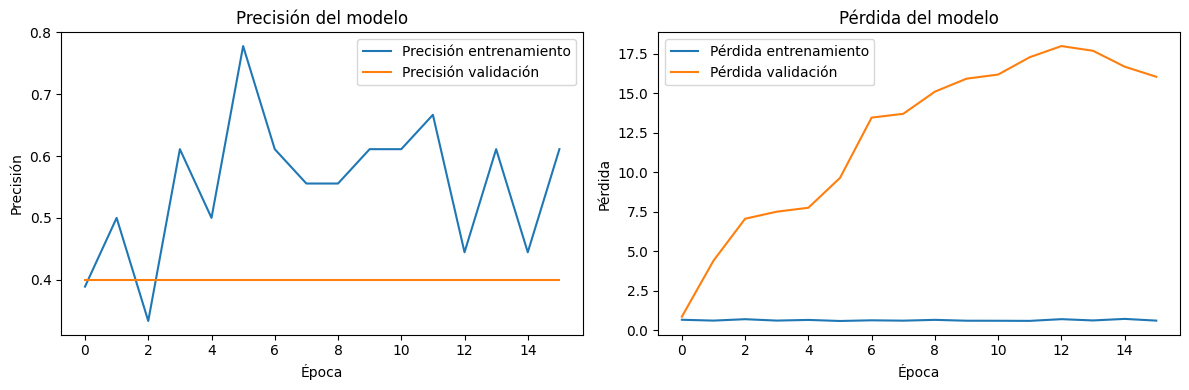

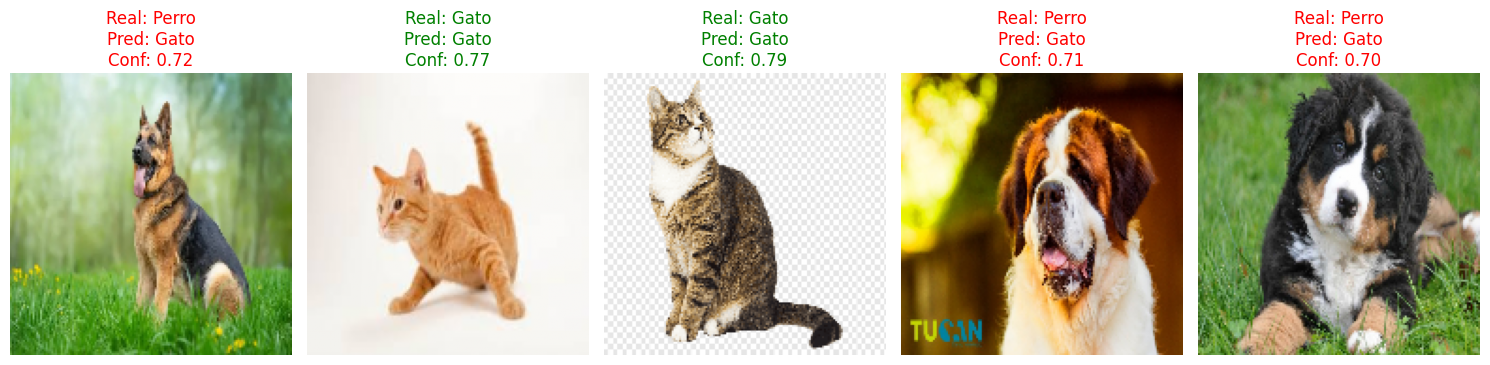

In [ ]:
# Celda 8: Evaluar y visualizar resultados
if 'modelo' in locals():
    # Evaluar el modelo
    if 'X_prueba' in locals() and X_prueba.shape[0] > 0:
        pérdida, precisión = modelo.evaluate(X_prueba, y_prueba, verbose=0)
        print(f"Precisión en datos de prueba: {precisión * 100:.2f}%")

        # También evaluar en entrenamiento para comparar
        pérdida_ent, precisión_ent = modelo.evaluate(X_entrenamiento, y_entrenamiento, verbose=0)
        print(f"Precisión en datos de entrenamiento: {precisión_ent * 100:.2f}%")

        # Calcular diferencia para detectar sobreajuste
        diferencia = abs(precisión_ent - precisión)
        if diferencia > 0.2:
            print("⚠️  Posible sobreajuste detectado (diferencia > 20%)")
        elif diferencia > 0.1:
            print("⚠️  Ligero sobreajuste detectado (diferencia > 10%)")
        else:
            print("✅ Buen equilibrio entre entrenamiento y prueba")

    else:
        # Si no hay datos de prueba, evaluar con datos de entrenamiento
        pérdida, precisión = modelo.evaluate(X_entrenamiento, y_entrenamiento, verbose=0)
        print(f"Precisión en datos de entrenamiento: {precisión * 100:.2f}%")

    # Graficar precisión y pérdida
    plt.figure(figsize=(12, 4))

    if 'historial' in locals():
        plt.subplot(1, 2, 1)
        if 'accuracy' in historial.history:
            plt.plot(historial.history['accuracy'], label='Precisión entrenamiento')
        if 'val_accuracy' in historial.history:
            plt.plot(historial.history['val_accuracy'], label='Precisión validación')
        plt.title('Precisión del modelo')
        plt.xlabel('Época')
        plt.ylabel('Precisión')
        plt.legend()

        plt.subplot(1, 2, 2)
        if 'loss' in historial.history:
            plt.plot(historial.history['loss'], label='Pérdida entrenamiento')
        if 'val_loss' in historial.history:
            plt.plot(historial.history['val_loss'], label='Pérdida validación')
        plt.title('Pérdida del modelo')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Probar con algunas imágenes
    if 'X' in locals() and X.shape[0] > 0:
        plt.figure(figsize=(15, 5))
        num_ejemplos = min(5, X.shape[0])

        for i in range(num_ejemplos):
            plt.subplot(1, num_ejemplos, i + 1)
            img = X[i]
            predicción = modelo.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
            etiqueta_pred = "Perro" if predicción > 0.5 else "Gato"
            confianza = predicción if predicción > 0.5 else 1 - predicción
            etiqueta_real = "Perro" if y[i] == 1 else "Gato"

            plt.imshow(img)
            # Color verde si es correcto, rojo si es incorrecto
            color = 'green' if etiqueta_pred == etiqueta_real else 'red'
            plt.title(f'Real: {etiqueta_real}\nPred: {etiqueta_pred}\nConf: {confianza:.2f}', color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
# Celda 9: Guardar y convertir el modelo
if 'modelo' in locals():
    # Guardar modelo en formato Keras
    modelo.save('modelo_perros_gatos.h5')
    print("Modelo guardado como 'modelo_perros_gatos.h5'")

    # Convertir a TensorFlow.js
    !mkdir -p modelo_tfjs
    !tensorflowjs_converter --input_format keras modelo_perros_gatos.h5 modelo_tfjs/
    print("Modelo convertido a TensorFlow.js")

    # Verificar archivos generados
    print("\nArchivos en modelo_tfjs:")
    !ls -la modelo_tfjs/
else:
    print("No hay modelo para guardar.")

Modelo guardado como 'modelo_perros_gatos.h5'
2025-08-21 04:19:12.677394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755749952.701977   54678 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755749952.709331   54678 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755749952.729026   54678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755749952.729068   54678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755749952.729072   54678 com

In [ ]:
# Celda 10: Descargar el modelo
from google.colab import files

if os.path.exists('modelo_tfjs'):
    # Comprimir la carpeta del modelo
    !zip -r modelo_tfjs.zip modelo_tfjs/

    # Descargar
    print("\nDescargando modelo...")
    files.download('modelo_tfjs.zip')
    print("¡Modelo descargado! Ahora puedes usarlo en Visual Studio Code.")
else:
    print("No se encontró la carpeta del modelo para descargar.")

  adding: modelo_tfjs/ (stored 0%)
  adding: modelo_tfjs/group1-shard1of2.bin (deflated 8%)
  adding: modelo_tfjs/model.json (deflated 85%)
  adding: modelo_tfjs/group1-shard2of2.bin (deflated 8%)

Descargando modelo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Modelo descargado! Ahora puedes usarlo en Visual Studio Code.
